# Knowledge Graphs Introduction.

The [slides from NEO4j](https://www.slideshare.net/neo4j/knowledge-graphs-the-power-of-graphbased-search?from_action=save) are a good point to start.
I strongly recommend you to explore these slides:
* 3-7
* 23-25
* 32-34

This [slides from Microsoft](https://kdd2018tutorialt39.azurewebsites.net/KDD%20Tutorial%20T39.pdf) are more academic but they pinpoint the actual research topics on the field.


# Neo4j

You *need* to set up Neo4j, follow the [README](readme.md) instructions.

In [3]:
from neo4j import GraphDatabase
from json import dumps
import time
from pandas import DataFrame
from pandas import read_json
import requests
import jmespath

In [2]:
class KnowledgeRecommendation(object):

    def __init__(self, uri, user, password):
        self._driver = GraphDatabase.driver(uri, auth=(user, password))
        self.session = self._driver.session()

    def close(self):
        self._driver.close()
    
    def serialize_movie(self,movie):
        return {
            'id': movie['id'],
            'title': movie['title'],
#             'summary': movie['description'],
            'released': movie.get('releaseDate'),
            'duration': movie['runtime'],
            'rated': movie['rated'],
            'imdbId': movie['imdbId'],
            'genre': movie['genre']
        }
    
    def movie(self,title):
        query = ('MATCH (movie:Movie) ' +
                 f'WHERE movie.title =~ "{title}" ' +
                 'RETURN movie')
        results = self.session.run(query)
        return [self.serialize_movie(record['movie']) for record in results.data()]
    
    def same_genre_movies(self, title):
        query = ('MATCH (movie:Movie) ' +
                 f'WHERE movie.title = "{title}" '+
                'WITH movie.genre as genre '+
                'MATCH (movies:Movie) '+
                'WHERE movies.genre = genre '+
                'RETURN movies.title, movies.releaseDate, movies.genre, movies.imdbId '+
                'LIMIT 100')
        results = self.session.run(query)
#         return [self.serialize_movie(record['movies']) for record in results.data()] # you should only return movies
        return results.data()
    
    def movies_by_movie_director(self, title):
        query = ('MATCH (movie:Movie)<-[:DIRECTED]-(director:Director) '+
                f'WHERE movie.title = "{title}" '+
                'MATCH (movies:Movie)<-[:DIRECTED]-(director) '+
                'RETURN movies.title, movies.releaseDate, movies.genre, movies.imdbId '+
                'LIMIT 100')
        results = self.session.run(query)
        return results.data()
    
    def movies_by_actor(self,actor):
        query = ('MATCH (movies:Movie)<-[:ACTS_IN]-(actor:Actor) '+
                f'WHERE actor.name = "{actor}" '+
                'RETURN movies.title, movies.releaseDate, movies.genre, movies.imdbId ')
        results = self.session.run(query)
        return results.data()
    
    def movies_by_actor_and_genre(self,actor, genre):
        query = ('MATCH (movies:Movie)<-[:ACTS_IN]-(actor:Actor) '+
                f'WHERE actor.name = "{actor}" and movies.genre="{genre}" '+
                'RETURN movies.title, movies.releaseDate, movies.genre, movies.imdbId ')
        results = self.session.run(query)
        return results.data()
    
    def movies_shared_actors_with_genre(self,actor, genre):
        query = ('MATCH (actor:Actor)-[:ACTS_IN]->(movie:Movie)<-[:ACTS_IN]-(actors:Actor) ' +
            f'WHERE actor.name = "{actor}" ' +
            'WITH actors ' +
            'MATCH (actors)-[:ACTS_IN]->(movies:Movie) ' +
           f'WHERE movies.genre="{genre}" ' +
            'RETURN movies.title, movies.releaseDate, movies.genre, movies.imdbId ' +
            'LIMIT 100 ' )
        print(query)
        results = self.session.run(query)
        return results.data()
        
    
graph = KnowledgeRecommendation("bolt://localhost:11004", "neo4j", "123456")

In [3]:
avatar = graph.movie("Jurassic Park")
print(avatar)

[{'id': '329', 'title': 'Jurassic Park', 'released': '739749600000', 'duration': 127, 'rated': None, 'imdbId': 'tt0107290', 'genre': 'Action'}]


In [4]:
other_movies = graph.same_genre_movies("Jurassic Park")
DataFrame(other_movies)

,movies.genre,movies.imdbId,movies.releaseDate,movies.title
0,Action,tt0499549,1261090800000,Avatar
1,Action,tt0093058,551656800000,Full Metal Jacket
2,Action,tt0083866,391212000000,E.T.: The Extra-Terrestrial
3,Action,tt0116629,835653600000,Independence Day
4,Action,tt0133093,922831200000,The Matrix
5,Action,tt0234215,1052258400000,The Matrix Reloaded
6,Action,tt0242653,1067209200000,The Matrix Revolutions
7,Action,tt0119654,867708000000,Men In Black
8,Action,tt0120912,1025647200000,Men In Black II
9,Action,tt0109830,772322400000,Forrest Gump


In [ ]:
movies_director = graph.movies_by_movie_director("Jurassic Park")
DataFrame(movies_director)

In [ ]:
actor = graph.movies_by_actor("Michael J. Fox")
DataFrame(actor)

In [ ]:
actor_and_genre = graph.movies_by_actor_and_genre("Michael J. Fox", "Action")
DataFrame(actor_and_genre)

In [6]:
movies_other_actors_genre = graph.movies_shared_actors_with_genre("Michael J. Fox", "Animation")
DataFrame(movies_other_actors_genre)

NameError: name 'graph' is not defined

# SPARQL - WIKIDATA 

## Tutorials
[Best tutorial ever](https://janakiev.com/blog/wikidata-mayors/)

[Navegate the statements](https://en.wikibooks.org/wiki/SPARQL/WIKIDATA_Qualifiers,_References_and_Ranks)


## Explore a movie
Lets explore the [Jurassic Park](https://www.wikidata.org/wiki/Q167726) movie and see the information they show.

[Wikipedia](https://en.wikipedia.org/wiki/Jurassic_Park_(film)) uses this info.


### Useful attributes for movies
Awardsrecieved https://www.wikidata.org/wiki/Property:P166

main subject https://www.wikidata.org/wiki/Property:P921

genre https://www.wikidata.org/wiki/Property:P136

box office https://www.wikidata.org/wiki/Property:P2142

# Graph exploration
[Graphs](https://query.wikidata.org/embed.html#SELECT%20DISTINCT%20%3Fnew_movies%20%3Fnew_moviesLabel%20%3Fproduction_company%20WHERE%20%7B%0A%20%20SERVICE%20wikibase%3Alabel%20%7B%20bd%3AserviceParam%20wikibase%3Alanguage%20%22en%22.%20%7D%0A%20%20%3Fmovie%20wdt%3AP345%20%22tt4154796%22.%0A%20%20OPTIONAL%20%7B%0A%20%20%20%20%3Fmovie%20wdt%3AP272%20%3Fproduction_company.%0A%20%20%20%20%3Fnew_movies%20wdt%3AP31%20wd%3AQ11424%3B%0A%20%20%20%20%20%20wdt%3AP272%20%3Fproduction_company.%0A%20%20%7D%0A%7D%0AORDER%20BY%20(%3Fproduction_companyLabel))

# SPARQL exploration
[Learning prefixes](https://www.mediawiki.org/wiki/Wikidata_Query_Service/User_Manual#Basics_-_Understanding_Prefixes)

In [6]:
op = 1
if op == 1:
    query = """SELECT ?movie ?movieLabel ?main_subjectLabel ?genreLabel ?box WHERE {
      ?movie wdt:P345 "tt0107290";
        wdt:P921 ?main_subject;
        wdt:P136 ?genre.
      ?movie p:P2142 ?statement.
      ?statement ps:P2142 ?box
      SERVICE wikibase:label { bd:serviceParam wikibase:language "en". }
    }"""
elif op==2:
    query = """
        SELECT 
          ?countryLabel ?population ?area ?medianIncome ?age
        WHERE {
          ?country wdt:P463 wd:Q458.
          OPTIONAL { ?country wdt:P1082 ?population }
          OPTIONAL { ?country wdt:P2046 ?area }
          OPTIONAL { ?country wdt:P3529 ?medianIncome }
          OPTIONAL { ?country wdt:P571 ?inception. 
            BIND(year(now()) - year(?inception) AS ?age)
          }
          SERVICE wikibase:label { bd:serviceParam wikibase:language "en". }
        }"""
elif op == 3: #most box_office movies
    query =  """ 
    SELECT DISTINCT ?movie ?movieLabel ?box WHERE {
      SERVICE wikibase:label { bd:serviceParam wikibase:language "en". }
      ?movie wdt:P31 wd:Q11424;
        p:P2142 ?statement;
        p:P495 ?country_statement.
      ?statement ps:P2142 ?box.
      ?country_statement ps:P495 wd:Q30.
      FILTER(?box >= 623933331 )
    }
    ORDER BY DESC (?box)
    LIMIT 100
    """
elif op == 4: #production_company for most successful movies
    query = """
    SELECT DISTINCT ?movie ?movieLabel ?box ?prod_companyLabel WHERE {
      SERVICE wikibase:label { bd:serviceParam wikibase:language "en". }
      OPTIONAL {
        ?movie p:P272 ?prod_company_statement.
        ?prod_company_statement ps:P272 ?prod_company.
      }
      {
        SELECT * WHERE {
          ?movie wdt:P31 wd:Q11424;
            p:P2142 ?statement;
            p:P495 ?country_statement.
          ?statement ps:P2142 ?box.
          ?country_statement ps:P495 wd:Q30.
          FILTER(?box >= 623933331 )
        }
        LIMIT 100
      }
    }
    ORDER BY DESC (?box)
    LIMIT 10"""
elif op == 5: # other movies from the most successful production production company 
    query = """
    SELECT DISTINCT ?movieLabel ?box ?prod_companyLabel ?extra_movieLabel WHERE {
      SERVICE wikibase:label { bd:serviceParam wikibase:language "en". }
      ?extra_movie p:P272 ?prod_company_statement.
      ?prod_company_statement ps:P272 ?prod_company.
      {
        SELECT ?movie ?prod_company ?box WHERE {
          OPTIONAL {
            ?movie p:P272 ?prod_company_statement.
            ?prod_company_statement ps:P272 ?prod_company.
          }
          {
            SELECT * WHERE {
              ?movie wdt:P31 wd:Q11424;
                p:P2142 ?statement;
                p:P495 ?country_statement.
              ?statement ps:P2142 ?box.
              ?country_statement ps:P495 wd:Q30.
              FILTER(?box >= 623933331 )
            }
            LIMIT 100
          }
        }
        ORDER BY DESC (?box)
        LIMIT 2
      }
    }
    ORDER BY DESC (?prod_companyLabel)"""

In [7]:
url = 'https://query.wikidata.org/sparql'

r = requests.get(url, params = {'format': 'json', 'query': query})
data = {}
data = r.json()

data = jmespath.search("values({headers:[head.vars], data:results.bindings | map(&values(@),@)[*][*].value})[]", data)
headers = data.pop(0)
data = DataFrame(data, columns=headers)
# data.box = data.box.astype(float)

In [8]:
data

,movie,movieLabel,main_subjectLabel,genreLabel,box
0,http://www.wikidata.org/entity/Q167726,1029528120,Jurassic Park,dinosaur,action film
1,http://www.wikidata.org/entity/Q167726,1029528120,Jurassic Park,dinosaur,horror film
2,http://www.wikidata.org/entity/Q167726,1029528120,Jurassic Park,dinosaur,adventure film
3,http://www.wikidata.org/entity/Q167726,1029528120,Jurassic Park,dinosaur,science fiction film
4,http://www.wikidata.org/entity/Q167726,1029528120,Jurassic Park,dinosaur,film based on literature


In [40]:
data.box.var()

1.103392331255885e+17

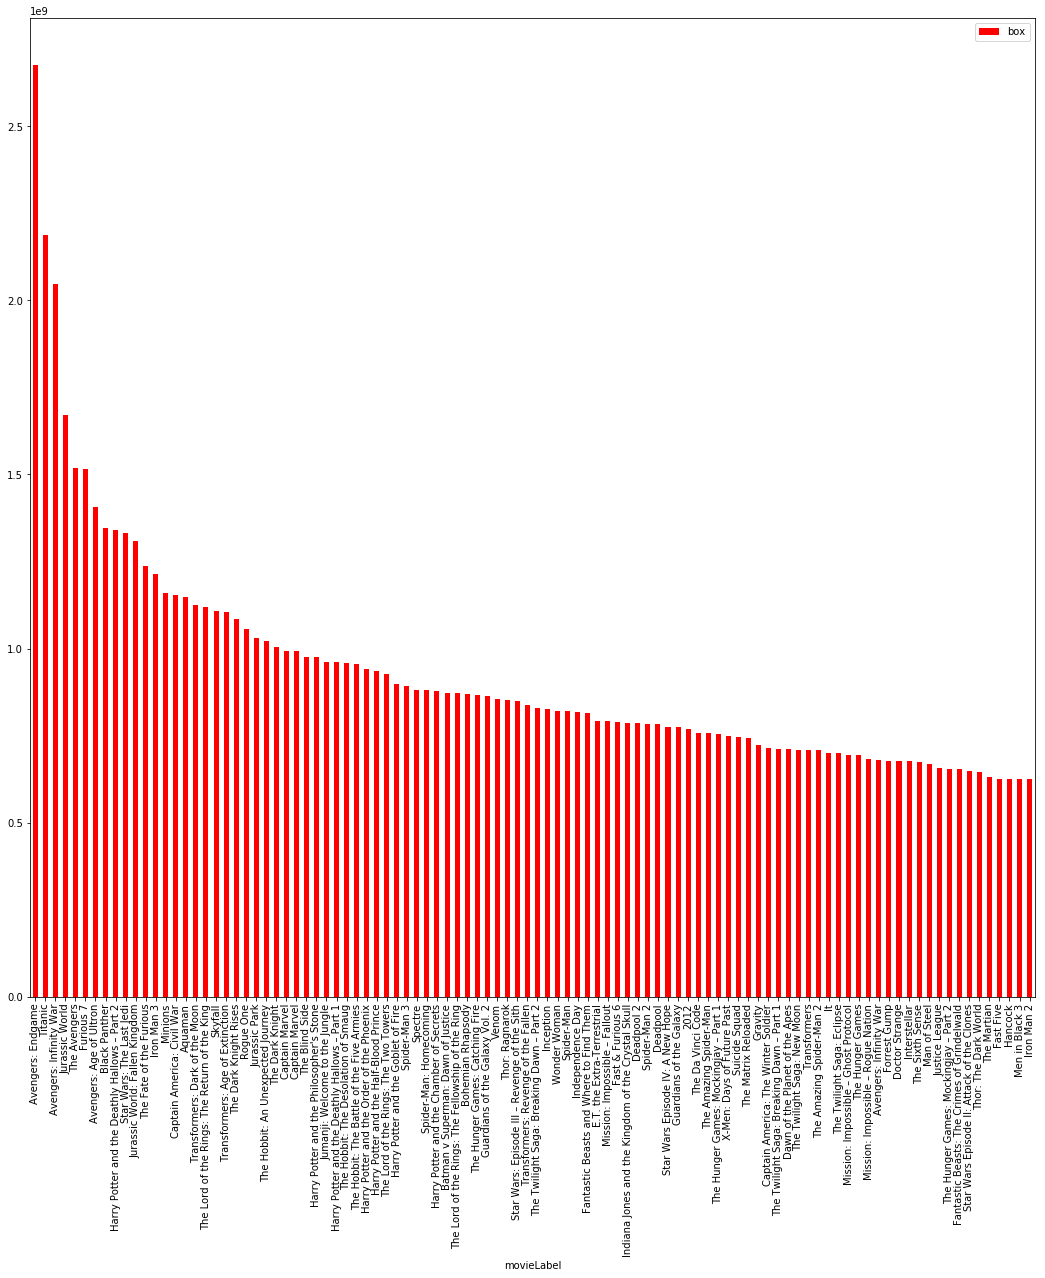

In [51]:
data.plot(kind='bar',x='movieLabel',y='box',color='red', figsize=(18,18))